# Using Nemotron Parse (aka Eclair) for Table and Text Extraction


# 1. Introduction

## Models

1. Nemotron Parse (aka Eclair): this is a locally hosted model that we will setup in in the next section 

## Pipeline

1. Given an image of the page, the `Eclair` model runs the segmentation and identifies elements on teh page. 
2. `Eclair` classifies the element roughly as `text`, `table`, or `picture`. 
3. If an item is identified as a `text`, we simply retrieve the contents extracted by Eclair
4. If an item is identified as a `table`, we retrieve the contents exttracted by Eclair. Eclair presents the table as Latex format, so we add an post-processing step to conver that to HTML format for better readability. 
5. If an item is identified as `picture`, we do not do anything about it. 
6. The pipeline saves ouput files 

# 2. Setup and Prerequisites

## Prerequisites

- NVIDIA GPU with CUDA support, such as A10, L4, L40, A100, H100, etc
- CUDA Driver Version >= 12.8 < 13.0
- Docker (for container-based setup) or a virtual machine image


## 2.1. Environment Setup

### Option 1: Using a Base Container Image

Start with the NVIDIA CUDA development container:

```bash
docker run -it --rm --gpus all nvcr.io/nvidia/cuda-dl-base:25.05-cuda12.9-devel-ubuntu24.04 /bin/bash
```

Verify CUDA toolkit installation:

```bash
nvcc --version
```

Expected output:

```text
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Apr__9_19:24:57_PDT_2025
Cuda compilation tools, release 12.9, V12.9.41
Build cuda_12.9.r12.9/compiler.35813241_0
```

> **Note:** The host CUDA version (from `nvidia-smi`) must be >=  the runtime CUDA version (from `nvcc` command). Host CUDA version can be 13.0, but limit runtime CUDA version to 12.8 - 12.9

Install Python development packages:

```bash
apt-get update && apt-get install -y python3.12-dev
```

### Option 2: Directly Using a Virtual Machine Image

If running directly on a VMI without a container:

```bash
nvidia-smi
```

Ensure the output shows `CUDA Version: 12.8` or `12.9`

## 2.2 Verify CUDA_HOME (Optional but Recommended)

> **Warning:** Without properly setting `CUDA_HOME`, vLLM wheel compilation might fail

Check if `CUDA_HOME` is set:

```bash
echo "CUDA_HOME: $CUDA_HOME" && echo "PATH: $PATH" | grep cuda
```

The output should show file paths pointing to `/usr/local/cuda/bin` or similar. Base container images typically have this pre-configured.

## 2.3. Python Environment Setup

```bash
curl -LsSf https://astral.sh/uv/install.sh | sh && source $HOME/.local/bin/env
```

Re-open your terminal or source the environment, then create a Python virtual environment:

```bash
# Create UV environment with Python 3.12
uv venv --python 3.12 --seed
source .venv/bin/activate
```

## 2.4. Install vLLM

```bash
uv pip install vllm==0.15.1
```

## 2.5 Install Additional Dependencies

```bash
uv pip install timm albumentations open-clip-torch
```

## 2.6 Launch vLLM Server

> **Tip:** The official repository uses the vLLM Python SDK. This setup includes a `template.jinja` file to enable vLLM server usage.

### Create Chat Template

Create a `template.jinja` file in your working directory (included with this repo)

```jinja
{% for message in messages %}{{ message['content'] }}{% endfor %}
```

### Start the Server

```bash
vllm serve nvidia/NVIDIA-Nemotron-Parse-v1.1 \
    --dtype bfloat16 \
    --max-num-seqs 4 \
    --limit-mm-per-prompt '{"image": 1}' \
    --trust-remote-code \
    --port 8000 \
    --chat-template template.jinja
```

**Notes**: 
- When running on A100/A10 , add  `--attention-backend=TRITON_ATTN` otherwise the model might babble nonsense data
- Adjust `--max-num-seqs` based on your GPU capacity (4 is suitable for an L4 GPU)
- The server will be available at `http://localhost:8000`

Follow the provided notebooks to interact with the Nemotron Parse model.

# 3. Pipeline Configs

## Dependencies

First, let's set up the environment. You'll need to install the required Python libraries.

In [ ]:
# %pip install requests pillow ipython openai beautifulsoup4 seaborn python-dotenv loguru pymupdf

## Pipeline Configurations

In [1]:
import os
from datetime import datetime, timezone
import base64
from PIL import Image
from io import BytesIO
import pandas as pd
from IPython.display import display, Markdown, HTML
import requests
from openai import OpenAI
import json
from loguru import logger

# load environment variables
from dotenv import load_dotenv
load_dotenv()

# --- Configs for the Eclair model ---
DOCKER_HOST = "localhost"  # Updated Docker host IP 10.176.12.87
ECLAIR_PORT = 8000            # Your Docker host port
ECLAIR_ENDPOINT_PATH = "/v1/chat/completions"      # The API endpoint path
ECLAIR_ENDPOINT_URL = f"http://{DOCKER_HOST}:{ECLAIR_PORT}{ECLAIR_ENDPOINT_PATH}"

# --- Output Directory Configuration ---
OUTPUT_DIR = "output_results"
output_annotated_dir = os.path.join(OUTPUT_DIR, "annotated_images")
output_json_dir = os.path.join(OUTPUT_DIR, "json_outputs")

# 4. Collect Example Document Images

In this step, we collect the example images we want to analyze in a list 

In [2]:
def preprocess_image_like_eclair(image, target_w=1648, target_h=2048):
    """
    Place image on the smallest possible "paper" with aspect ratio target_w:target_h.
    Don't downscales the image - keeps original size to prevent blurriness.
    Place the image in the center of a new canvas. 
    This canvas should have a w:h ratio = target_w:target_h. ([3, 1648, 2048] is the input image size of Eclair)
    The canvas should be the smallest possible size that fits the image without downscaling the image. 
    Returns:
        PIL Image on paper with aspect ratio target_w:target_h
    """

    import numpy as np
    
    img_array = np.array(image)

    original_height, original_width = img_array.shape[:2]
        
    # Calculate target aspect ratio (paper ratio)
    target_ratio = target_w / target_h
    
    # Step 1: Determine if we need to scale up (don't scale down)
    scale_for_height = target_h / original_height
    scale_for_width = target_w / original_width
    scale = max(scale_for_height, scale_for_width, 1.0)  # Never less than 1.0
    
    # Calculate image dimensions after potential scaling up
    if scale > 1.0:
        image_width = int(original_width * scale)
        image_height = int(original_height * scale)
        resized_image = image.resize((image_width, image_height), Image.Resampling.LANCZOS)
    else:
        # Keep original size (no downscaling)
        image_width = original_width
        image_height = original_height
        resized_image = image
    
    # Step 2: Calculate smallest paper size with target ratio that fits the image
    # paper_width / paper_height = target_ratio
    # paper_width >= image_width AND paper_height >= image_height
    
    # Option 1: Match height, calculate width
    paper_h_option1 = image_height
    paper_w_option1 = int(paper_h_option1 * target_ratio)
    
    # Option 2: Match width, calculate height  
    paper_w_option2 = image_width
    paper_h_option2 = int(paper_w_option2 / target_ratio)
    
    # Choose the option that fits both dimensions
    if paper_w_option1 >= image_width and paper_h_option1 >= image_height:
        paper_width = paper_w_option1
        paper_height = paper_h_option1
    else:
        paper_width = paper_w_option2
        paper_height = paper_h_option2
    
    # Step 3: Create paper with white background
    resized_array = np.array(resized_image)
    
    # Handle grayscale images
    if len(resized_array.shape) == 2:
        resized_array = np.stack([resized_array] * 3, axis=-1)
    
    # Create white paper
    paper_array = np.ones((paper_height, paper_width, 3), dtype=np.uint8) * 255
    
    # Center the image on the paper
    pad_left = (paper_width - image_width) // 2
    pad_top = (paper_height - image_height) // 2
    
    paper_array[pad_top:pad_top+image_height, pad_left:pad_left+image_width] = resized_array


    # Create final image and set DPI to 300
    result_image = Image.fromarray(paper_array)
    # result_image.info['dpi'] = (300, 300)
    
    return result_image

In [3]:
import os, re, itertools
from glob import glob
from pathlib import Path
import shutil

def load_and_resize_image(image_path, save=False, save_dir=None):
    """
    Load an image from the given path and resize it to 2048x1648 (height x width).
    
    Args:
        image_path (str): Path to the input image
        save (bool): If True, save the resized image with a '_resized' suffix
        
    Returns:
        str: Path to the resized image (either saved or original path)
    """
    from PIL import Image
    import os
    
    # Load the image, convert to RGB if necessary
    img = Image.open(image_path)

    # Resize to (width, height) - PIL uses (width, height) format
    # Target: height=2048, width=1648
    # target_size = (1648, 2048)  # (width, height) for PIL
    # resized_img = img.resize(target_size ,Image.Resampling.LANCZOS)
    resized_img = preprocess_image_like_eclair(image = img)

    if save:
        # Create resized file path
        path_parts = os.path.splitext(image_path)
        # if save_dir is not None, use it
        if save_dir is not None:
            # get base file name
            base_name = os.path.basename(image_path)
            # split the file name into name and extension
            name, ext = os.path.splitext(base_name)
            resized_path = os.path.join(save_dir, f"{name}_resized{ext}")
        else:
            resized_path = f"{path_parts[0]}_resized{path_parts[1]}"
        
        # Save the resized image
        resized_img.save(resized_path)
        return resized_path
    else:
        return image_path



def get_all_paths(patterns, data_root, workspace_root, resize=True):

    """
    This function gets all the paths of the converted images, and resize them if needed
    patterns: list of patterns to match the converted images
    data_root: str, the root of the converted images
    workspace_root: str, the root of the workspace
    resize: bool, whether to resize the images
    returns: list of paths to the processed images
    """

    # get all the paths of the converted images
    all_paths_abs = []
    for pat in patterns:
        all_paths_abs.extend(glob(pat, recursive=True))

    # Dedup + natural sort (so _page_2_ comes before _page_10_)
    def _natural_key(s: str):
        return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]
    all_paths_abs = sorted(set(all_paths_abs), key=_natural_key)

    # create a folder to save the resized images
    save_dir = data_root / "resized_images"
    if save_dir is not None:
        # delete the file if it exists
        if os.path.exists(save_dir):
            # delete directory and all its contents
            shutil.rmtree(save_dir)
        os.makedirs(save_dir)

    # add resized images to the list
    allowed_page_paths = []
    for p in all_paths_abs:
        if resize: 
            resized_fp = load_and_resize_image(p, save=True, save_dir=save_dir)
            # convert to repo‑relative paths
            rel = os.path.relpath(resized_fp, workspace_root).replace("\\", "/")
        else: 
            rel = os.path.relpath(p, workspace_root).replace("\\", "/")
        allowed_page_paths.append(rel)

    # sort the paths
    allowed_page_paths = sorted(set(allowed_page_paths), key=_natural_key)

    print(f"✅ Collected a total of {len(allowed_page_paths)} image pages")
    print("Here are the first 10 input image paths:")
    for sample in itertools.islice(allowed_page_paths, 10):
        print(" -", sample)
        
    return allowed_page_paths

In [5]:
# Root of the notebook
WORKSPACE_ROOT = Path.cwd()
# Root of the converted imaages folder, from step 1 notebook
DATA_ROOT = WORKSPACE_ROOT / "output_results" 

# Patterns covering both pipelines and direct converted images
# adjust accordingly to match the location of your converted images
PATTERNS = [
    str(DATA_ROOT / "converted_images" / "soa_1" / "fitz" / "*.png"),
    # str(DATA_ROOT / "converted_images" / "a_map" / "fitz" / "*.png")
]

# get the input file paths
# You can choose to enable to disable resizing 
# Sometimes it doesn't make much difference 
# Sometimes resizing helps make bbox visualization a bit more accurate
# Sometimes no-resizing makes detection a bit more accurate
# Test both and see what works best for your use case
ALLOWED_PAGE_PATHS = get_all_paths(
    patterns=PATTERNS, 
    data_root=DATA_ROOT, 
    workspace_root=WORKSPACE_ROOT, 
    resize=False # False: disable resizing
)


✅ Collected a total of 1 image pages
Here are the first 10 input image paths:
 - output_results/converted_images/soa_1/fitz/soa_1_page_1_fitz.png


## 5. The Core Pipeline in Action

Now, let's walk through the code that powers our pipeline.


In [6]:
import re
from typing import List, Dict, Any, Union
from postprocessing import extract_classes_bboxes, postprocess_text, transform_bbox_to_original
from PIL import Image

def parse_content_to_blocks(content: str, width: int, height: int) -> List[Dict[str, Any]]:
    """Parse raw Eclair output into structured blocks using helpers from postprocessing.py."""

    # use the HF postprocessing function to extract the classes, bboxes and texts
    classes, bboxes, texts = extract_classes_bboxes(content)
    # transform the bboxes to the original image size
    bboxes = [transform_bbox_to_original(bbox, width, height) for bbox in bboxes]

    # Specify output formats for postprocessing
    table_format = 'HTML' # latex | HTML | markdown
    text_format = 'markdown' # markdown | plain
    blank_text_in_figures = False # remove text inside 'Picture' class
    texts = [postprocess_text(text, cls = cls, table_format=table_format, text_format=text_format, blank_text_in_figures=blank_text_in_figures) for text, cls in zip(texts, classes)]
    transformed_data: List[Dict[str, Any]] = []
    for cls, bbox, text in zip(classes, bboxes, texts):
        transformed_data.append({
            "type": cls,
            "text": text.strip(),
            "bbox": {
                "xmin": bbox[0],
                "ymin": bbox[1],
                "xmax": bbox[2],
                "ymax": bbox[3],
            },
        })
    return transformed_data

def parse_response(resp: Union[List, Dict], width: int, height: int) -> List[Dict[str, Any]]:
    
    # in rc1.5, use this: 
    content = resp['choices'][0]["message"]["content"]
    return parse_content_to_blocks(content = content, width = width, height = height)

    # in GA 1.0, use this: 
    # return json.loads(resp['choices'][0]['message']['tool_calls'][0]['function']['arguments'])[0]

def encode_file_to_base64(image_path: str):
    with open(image_path, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode('utf-8')

    ext = os.path.splitext(image_path)[1].lower()
    if ext in ('.jpg', '.jpeg'):
        mime = 'image/jpeg'
    elif ext == '.png':
        mime = 'image/png'
    else:
        # raise warning
        mime = 'image/' + ext
        print(f"Warning: Imeage extension is {ext}. Not all image types are supported. It might be best to convert to .png, .jpg, .jpeg instead. For now we will try to encode it as {mime}")

    return "data:" + mime + ";base64," + image_b64

def call_eclair_inference(image_path: str, temperature: float = 0.5):
    """
    Sends an image to the local Docker inference endpoint and transforms the
    output to the format expected by the rest of the script.
    Args:
        image_path (str): The path to the image to send to the Docker endpoint.
    Returns:
        list: A list of dictionaries, each representing a block in the image.
    """
    image_filename = os.path.basename(image_path)

    # convert to base64 encoded image
    image_b64 = encode_file_to_base64(image_path)
    print(f"    - Sending {image_filename} to Docker endpoint: {ECLAIR_ENDPOINT_URL}")

    try:
        payload = {
            "model": "nvidia/NVIDIA-Nemotron-Parse-v1.1",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "</s><s><predict_bbox><predict_classes><output_markdown>"},
                        {"type": "image_url", "image_url": {"url": image_b64}}
                    ]
                }
            ],
            "temperature": temperature,
            "top_k": 1,
            "repetition_penalty": 1.1,
            "max_tokens": 8000,
            "skip_special_tokens": False
        }
        response = requests.post(ECLAIR_ENDPOINT_URL, json=payload)
        response.raise_for_status()  # Raise an exception for bad status codes
        response_json = response.json()

        # DEBUG
        # return response_json
        # obtain the width and height of the image
        image = Image.open(image_path)
        width, height = image.size
        transformed_data = parse_response(resp = response_json, width = width, height = height)
        
        return transformed_data

    except requests.exceptions.RequestException as e:
        print(f"    - ERROR: Could not connect to Docker endpoint at {ECLAIR_ENDPOINT_URL}. Please ensure it is running. Details: {e}")
        return None
    except Exception as e:
        print(f"    - An unexpected error occurred during Docker inference: {e}")
        return None

In [7]:
# image_path = '/home/ubuntu/nemotron-parse-prod-hf/output_results/converted_images/test/fitz/test_page_1_fitz.png'

# resp = call_eclair_inference(
#     image_path = image_path, 
#     temperature=0
# )
# resp

### Drawing related helpers

In [8]:
import io
import re
from bs4 import BeautifulSoup
from PIL import ImageDraw, ImageFont

# Define the colors for each class. This is used to color the bounding boxes in the output image.
CLASS_COLORS = {
    'Text': '#4CAF50', 'Title': '#D32F2F', 'Section-header': '#E91E63',
    'List-item': '#1976D2', 'Table': '#03A9F4', 'Picture': '#6D4C41',
    'Caption': '#607D8B', 'Formula': '#FF9800', 'Page-header': '#BDBDBD',
    'Page-footer': '#BDBDBD', 'Footnote': '#00BCD4', 'Bibliography': '#512DA8',
    'TOC': '#FFC107', 'DEFAULT': '#9E9E9E'
}



def get_text_color(hex_color):
    """
    Gets the text color for a given hex color. Used to determine the color of the text in the bounding box.
    Args:
        hex_color (str): The hex color to get the text color for.
    Returns:
        str: The text color.
    """
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    luminance = (0.2126 * r + 0.7152 * g + 0.0722 * b)
    return "#000000" if luminance > 140 else "#FFFFFF"

def draw_annotations(image: Image.Image, extraction_data: list):
    """
    Draws the annotations on the image.
    Args:
        image (Image.Image): The image to draw the annotations on.
        extraction_data (list): The data to draw the annotations on.
    Returns:
        Image.Image: The image with the annotations drawn on it.
    """

    draw = ImageDraw.Draw(image)
    width, height = image.size
    
    box_thickness = max(3, int(width / 600))
    font_size = max(20, int(width / 100))
    try:
        font = ImageFont.truetype("Arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    for i, item in enumerate(extraction_data):
        bbox = item.get("bbox")
        if not bbox or bbox.get("xmax", 0) < bbox.get("xmin", 0) or bbox.get("ymax", 0) < bbox.get("ymin", 0):
            continue

        item_type = item.get("type", "DEFAULT")
        color = CLASS_COLORS.get(item_type, CLASS_COLORS['DEFAULT'])
        text_color = get_text_color(color)

        # Bounding boxes from parse_content_to_blocks are already in absolute pixel
        # coordinates (transform_bbox_to_original was already applied), so use them directly.
        left, top, right, bottom = (
            bbox["xmin"], 
            bbox["ymin"], 
            bbox["xmax"], 
            bbox["ymax"]
        )
        draw.rectangle([left, top, right, bottom], outline=color, width=box_thickness)

        label = f"ID: {i} | {item_type}"
        if item_type == 'Picture':
            label = f"ID: {i} | Picture:{item.get('sub_type', 'general')}"

        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_height = text_bbox[3] - text_bbox[1]
        text_width = text_bbox[2] - text_bbox[0]

        label_y_pos = top - text_height - (box_thickness * 2)
        if label_y_pos < 0: label_y_pos = top + (box_thickness * 2)

        label_bg = (left, label_y_pos, left + text_width + 10, label_y_pos + text_height + 10)
        draw.rectangle(label_bg, fill=color)
        draw.text((left + 5, label_y_pos + 5), label, fill=text_color, font=font)

    return image

## Executing the Pipeline

This cell is the pipeline's orchestrator. 

1. It iterates through each image path, calling the local Docker endpoint for initial layout parsing. 
2. All results are aggregated into structured JSON objects. 
3. `draw_annotations` is used to create a visualized output for each page. 
4. Additionally, it shows the HTML rendered content of detected tables. 


In [9]:
# ALLOWED_PAGE_PATHS = ALLOWED_PAGE_PATHS[:5]
ALLOWED_PAGE_PATHS

['output_results/converted_images/soa_1/fitz/soa_1_page_1_fitz.png']

🔍 Processing Page 1/1: output_results/converted_images/soa_1/fitz/soa_1_page_1_fitz.png
[Stage 1] Calling local parser for layout analysis...
    - Sending soa_1_page_1_fitz.png to Docker endpoint: http://localhost:8000/v1/chat/completions
[{'type': 'Page-header', 'text': '**_Symphogen Trial ID: Sym004-09_** # Clinical Trial Protocol Version 4.0', 'bbox': {'xmin': 394.0607, 'ymin': 188.7110358798283, 'xmax': 3107.9213000000004, 'ymax': 284.22676738197435}}, {'type': 'Text', 'text': 'Abbreviations (in alphabetical order): ADA, anti-drug antibody; C, Cycle; CT, computed tomography scan; D/d, day(s); DLT, dose-limiting toxicity; EOT, End of trial treatment Visit (Sym004 and FOLFIRI); ECG, electrocardiography; ECOG PS, Eastern Cooperative Oncology Group performance status; MRI, magnetic resonance imaging; 1M FUP, One Month Follow-up Visit; PK, pharmacokinetic; (S)AE, (serious) adverse event; TX, therapy', 'bbox': {'xmin': 390.5516999999999, 'ymin': 1970.7990674678113, 'xmax': 3084.0601, 'y

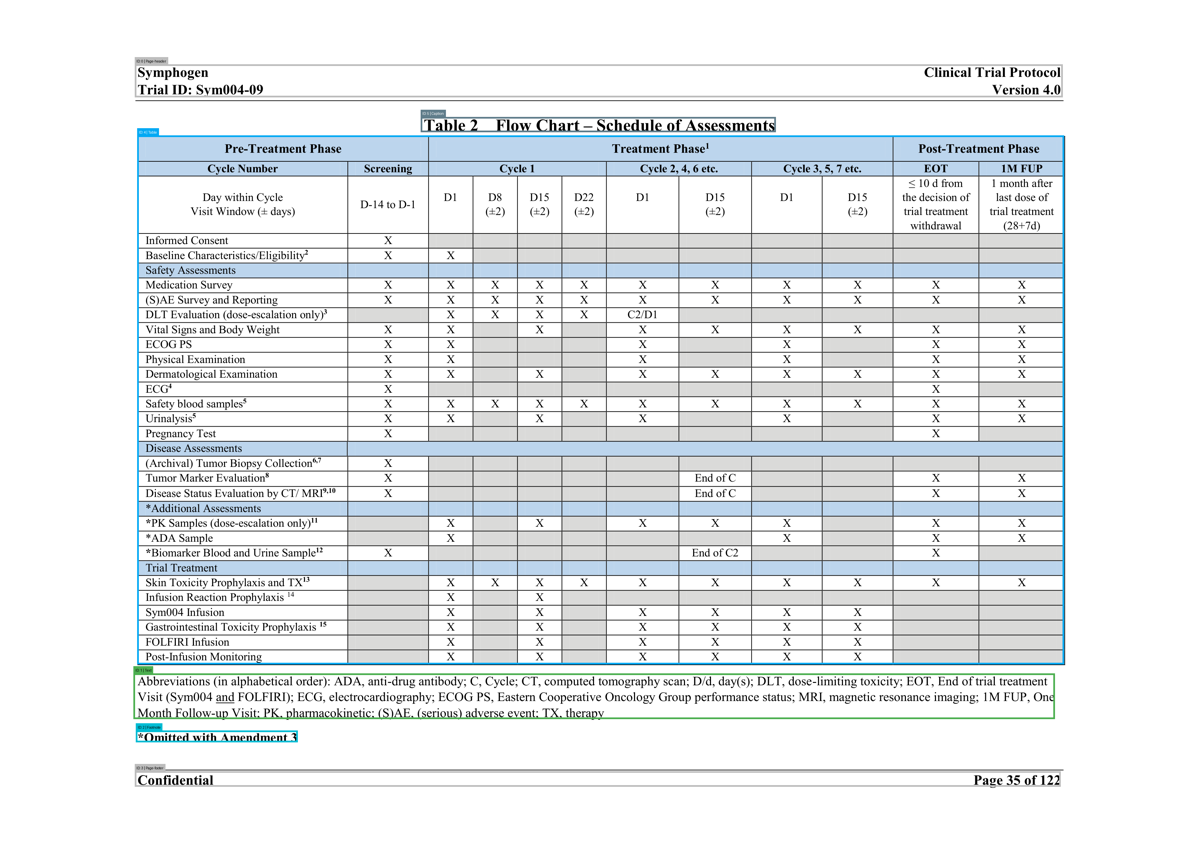

[Stage 2] Found Table (ID: 4). Parsing and reconstructing table...
- Cropped table patch for context:


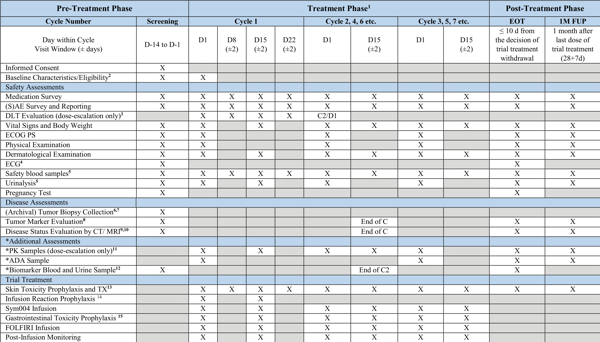

- Reconstructed HTML Table:


Annotated image saved as output_results/annotated_images/soa_1_page_1_fitz_annotated.png
JSON data saved as output_results/json_outputs/soa_1_page_1_fitz_extracted.json
--------------------------------------------------------------------------------
Processing complete.


In [10]:
# make output folders
for d in [output_annotated_dir, output_json_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

# initialize empty list to store all document data
all_document_data = []
total_pages = len(ALLOWED_PAGE_PATHS)

# iterate through each image path
for i, image_path_str in enumerate(ALLOWED_PAGE_PATHS):
    page_count = i + 1
    print(f"🔍 Processing Page {page_count}/{total_pages}: {image_path_str}")

    # if the file does not exist, fail silently
    if not os.path.exists(image_path_str):
        print(f" - ❌ ERROR: File not found. Skipping.")
        continue

    # read the image
    page_image = Image.open(image_path_str)
    filename_stem = os.path.splitext(os.path.basename(image_path_str))[0]

    # Stage 1: Call the Docker inference function for layout analysis
    print("[Stage 1] Calling local parser for layout analysis...")
    extracted_data = call_eclair_inference(
        image_path_str, 
        temperature=0
    )

    print(extracted_data)

    page_num_str = ''.join(filter(str.isdigit, filename_stem.split('_')[-1]))
    page_num = int(page_num_str) if page_num_str.isdigit() else 0

    # initialize the page entry to store the extracted data
    page_entry = {
        "source_document": image_path_str,
        "source_page_number": page_num,
        "processing_timestamp_utc": datetime.now(timezone.utc).isoformat(),
        "status": "",
        "content": []
    }

    # if the layout extraction failed, append the failed entry and continue
    if extracted_data is None:
        page_entry["status"] = "Layout extraction failed (Docker Inference)"
        all_document_data.append(page_entry) # Append failed entry and continue
        continue

    # if the layout extraction was successful, append the successful entry
    else:
        page_entry["status"] = "Layout extraction successful (Docker Inference)"
        print(f"[Stage 1] Found {len(extracted_data)} document objects.")

    # Draw annotations and save the visualized output
    annotated_image = draw_annotations(page_image.copy(), extracted_data)
    output_filename = os.path.join(output_annotated_dir, f"{filename_stem}_annotated.png")
    annotated_image.save(output_filename)
    print("\nDisplaying final annotated page:")
    display(annotated_image.resize((1200, int(1200 * annotated_image.height / annotated_image.width))))

    # Stage 2: Deep Analysis with llama-3.1-nemotron-nano-vl-8b-v1
    # iterate through each item in the extracted data
    for item_idx, item in enumerate(extracted_data):

        # initialize the item metadata
        item_metadata = {
            "extraction_id": item_idx,
            "metadata": {"source_page": page_num, "type": item.get("type"), "bbox": item.get("bbox")},
            "confidence": "N/A",
            "extraction_status": "Success",
            "data": {}
        }
        item_type = item.get("type")

        # if the item is a picture (not a table), just save the cropped image as it is 
        if item_type == "Picture":
            print(f"[Stage 2] Found Picture (ID: {item_idx}). Triggering Specialist VLM...")
            bbox = item.get("bbox")
            if not bbox or not all(k in bbox for k in ['xmin', 'ymin', 'xmax', 'ymax']) or bbox["xmax"] <= bbox["xmin"] or bbox["ymax"] <= bbox["ymin"]:
                logger.error(f"Invalid Bounding Box for Picture (ID: {item_idx}). Skipping.")
                item_metadata["extraction_status"] = "Failed (Invalid Bounding Box)"
                page_entry["content"].append(item_metadata)
                continue

            # Crop the image based on bounding box (already in absolute pixel coordinates)
            width, height = page_image.size
            crop_box = (max(0, bbox["xmin"]), max(0, bbox["ymin"]), min(width, bbox["xmax"]), min(height, bbox["ymax"]))

            if crop_box[0] >= crop_box[2] or crop_box[1] >= crop_box[3]:
                logger.error(f"Zero-Area Bounding Box for Picture (ID: {item_idx}). Skipping.")
                item_metadata["extraction_status"] = "Failed (Zero-Area Bounding Box)"
                page_entry["content"].append(item_metadata)
                continue

            cropped_img = page_image.crop(crop_box)
            print(f"- Cropped image: ")
            display(cropped_img.resize((200, int(200 * cropped_img.height / cropped_img.width))))

        # if the item is a table, parse the extraction results from Eclair, and reconstruct the table by converting LaTeX to HTML
        elif item_type == "Table":
            print(f"[Stage 2] Found Table (ID: {item_idx}). Parsing and reconstructing table...")

            # Show the detected table patch for context (bbox already in absolute pixel coordinates)
            bbox = item.get("bbox")
            if bbox:
                width, height = page_image.size
                crop_box = (max(0, bbox["xmin"]), max(0, bbox["ymin"]), min(width, bbox["xmax"]), min(height, bbox["ymax"]))
                if crop_box[0] < crop_box[2] and crop_box[1] < crop_box[3]:
                    cropped_table_img = page_image.crop(crop_box)
                    print(f"- Cropped table patch for context:")
                    display(cropped_table_img.resize((600, int(600 * cropped_table_img.height / cropped_table_img.width))))

            html_table = item.get("text", "")
            try:
                if not html_table:
                    raise ValueError("Empty HTML content for table")

                if "<table>" not in html_table:
                    raise ValueError("tabular environment not found or conversion failed.")

                # Display the result
                print(f"- Reconstructed HTML Table:")
                display(HTML(html_table))

                # Store the final HTML in the results
                item_metadata["data"] = {"type": "tabular", "content_html": html_table}

            except Exception as e:
                print(f"- ERROR: Failed to parse table data. Details: {e}")
                item_metadata["extraction_status"] = "Failed (Table Parsing Error)"
                item_metadata["data"] = {"error": f"Could not parse content: {e}", "raw_content": latex_code}
        
        # Fallback for any other type, like 'Text'
        else:
            item_metadata["data"] = {"type": "textual", "content": item.get("text", "")}

        page_entry["content"].append(item_metadata)

    # Save the individual JSON data for the page
    json_filename = os.path.join(output_json_dir, f"{filename_stem}_extracted.json")
    with open(json_filename, 'w') as f:
        json.dump(page_entry, f, indent=4)

    all_document_data.append(page_entry)
    print(f"Annotated image saved as {output_filename}")
    print(f"JSON data saved as {json_filename}")
    print("-" * 80)

print(f"Processing complete.")